In this Notebook moving weighted average, univariate time-series forecasting, Multivariate single and multi-step forcasting will be performed using LSTM cell. For this weather time-series dataset has been selected which was provided by "Max Planck Institute for Biogeochemistry"

Source/Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

# Importing Dataset 

In [2]:
#Importing the required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
print('Importing perfectly done')

Importing perfectly done


In [3]:
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

print(zip_path)

csv_path, _ = os.path.splitext(zip_path) 
print(csv_path)

13574144/13568290 [==============================] - 0s 0us/step
/root/.keras/datasets/jena_climate_2009_2016.csv.zip
/root/.keras/datasets/jena_climate_2009_2016.csv


In [4]:
#Displaying the extrated dataset
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.shape

(420551, 15)

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes for a time period of 7 years (from 2009 till 2016)

Observations:

1.   One reading every 10 mins
2.   1 day = 6*24 = 144 readings
3.   5 days = 144*5 = 720 readings


Here temperature(in deg C) is selected as target variable.

**Univariate Analysis**

In [6]:
uni_data_df=df['T (degC)'] #considering only temperature 
uni_data_df.index=df['Date Time'] #making data time as index(row names)
uni_data_df

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
                       ... 
31.12.2016 23:20:00   -4.05
31.12.2016 23:30:00   -3.35
31.12.2016 23:40:00   -3.16
31.12.2016 23:50:00   -4.23
01.01.2017 00:00:00   -4.82
Name: T (degC), Length: 420551, dtype: float64

**Checking for null values in the dataset**

In [7]:
uni_data_df.isnull().sum() # checking whether there are any null values, if there are any values either we can drop them or impute the values based on mean, median or mode

0

Ploting the temperature to find any patterns in the dataset

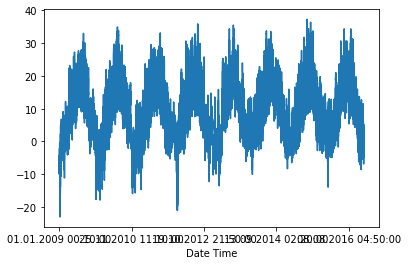

In [8]:
uni_data_df.plot()

It was clear that there is a clear pattern follows every year 

In [11]:
uni_data = uni_data_df.values # numpy ndarray from pandas

Normalize data: mean centering and variance-scaling.
Train data is only utilized to normalize the entire data set including the test and validation to avoid leakeage issue

In [12]:
TRAIN_SPLIT = 300000 # First 300.000 observations will be used as train data and rest as test data.
# 300.000 => ~2.100 days worth of training data

tf.random.set_seed(13) # random seed 

# Normalize data: mean centering and variance-scaling.
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


**Preparing dataset for constructing timeseries data**

In [13]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    x=dataset[indices]
    data.append(np.reshape(x, (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(299980, 20, 1)
(299980,)
(120531, 20, 1)
(120531,)


In [14]:
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):  #delta refers to what 
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

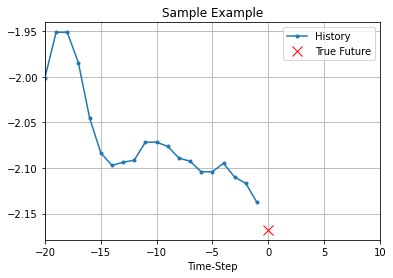

In [ ]:
show_plot([x_train_uni[5], y_train_uni[5]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

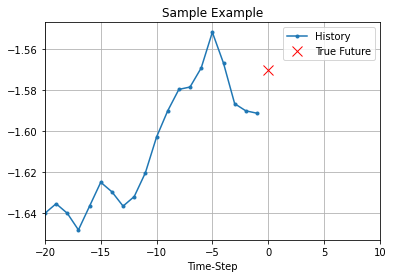

In [ ]:
show_plot([x_train_uni[120], y_train_uni[120]], 0, 'Sample Example')

In [ ]:
def mwa(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

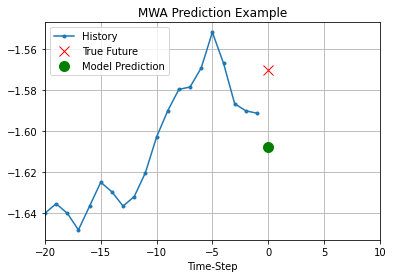

In [ ]:
show_plot([x_train_uni[120], y_train_uni[120],mwa(x_train_uni[120])], 0, 'MWA Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

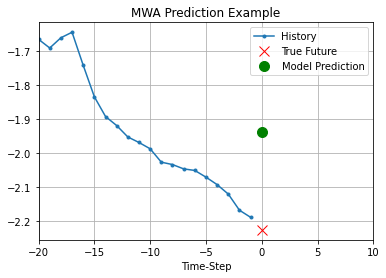

In [ ]:
show_plot([x_train_uni[1100], y_train_uni[1100],mwa(x_train_uni[1100])], 0, 'MWA Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

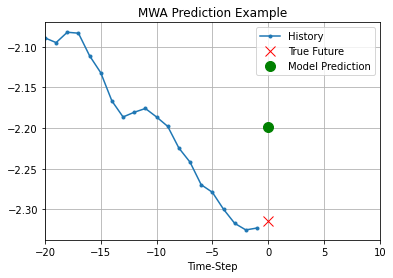

In [ ]:
i=1599
show_plot([x_train_uni[i], y_train_uni[i],mwa(x_train_uni[i])], 0, 'MWA Prediction Example')

## Univariate time-series forecasting

In [ ]:
BATCH_SIZE = 256 
BUFFER_SIZE = 10000 

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni)) #converts into tensorflow format
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()


val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 16)            1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
STEPS_PER_EPOCH = 200
EPOCHS = 30

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50,verbose=2)

Epoch 1/30
200/200 - 11s - loss: 0.1776 - val_loss: 0.0468
Epoch 2/30
200/200 - 7s - loss: 0.0497 - val_loss: 0.0334
Epoch 3/30
200/200 - 7s - loss: 0.0411 - val_loss: 0.0289
Epoch 4/30
200/200 - 7s - loss: 0.0350 - val_loss: 0.0271
Epoch 5/30
200/200 - 6s - loss: 0.0282 - val_loss: 0.0235
Epoch 6/30
200/200 - 7s - loss: 0.0296 - val_loss: 0.0209
Epoch 7/30
200/200 - 7s - loss: 0.0273 - val_loss: 0.0195
Epoch 8/30
200/200 - 7s - loss: 0.0239 - val_loss: 0.0176
Epoch 9/30
200/200 - 7s - loss: 0.0227 - val_loss: 0.0173
Epoch 10/30
200/200 - 6s - loss: 0.0205 - val_loss: 0.0169
Epoch 11/30
200/200 - 6s - loss: 0.0182 - val_loss: 0.0143
Epoch 12/30
200/200 - 6s - loss: 0.0200 - val_loss: 0.0135
Epoch 13/30
200/200 - 6s - loss: 0.0185 - val_loss: 0.0134
Epoch 14/30
200/200 - 7s - loss: 0.0184 - val_loss: 0.0127
Epoch 15/30
200/200 - 7s - loss: 0.0176 - val_loss: 0.0126
Epoch 16/30
200/200 - 7s - loss: 0.0162 - val_loss: 0.0126
Epoch 17/30
200/200 - 7s - loss: 0.0152 - val_loss: 0.0158
Epoch

In [36]:
def plt_train_val_acc(x,val_acc,train_acc,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_acc,'b',label="Validation Accuracy")
    plt.plot(x,train_acc,'r',label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy after each epoch')
    plt.legend()
    
def plt_train_val_loss(x,val_loss,train_loss,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_loss,'b',label="Validation Loss")
    plt.plot(x,train_loss,'r',label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Categorical Crossentropy loss')
    plt.legend()

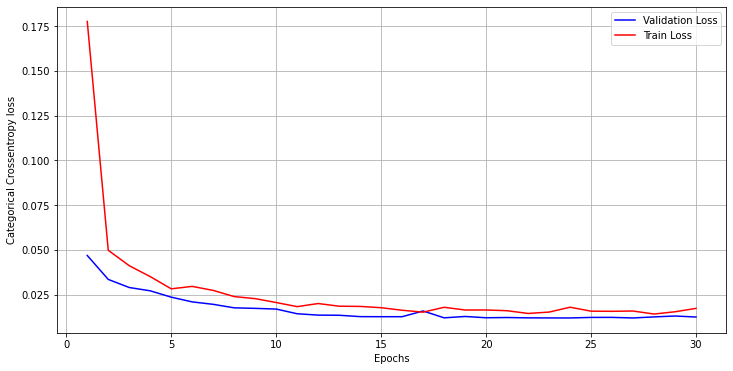

In [ ]:
epochs=30
history=simple_lstm_model.history

x=list(range(1,epochs+1))
val_loss=history.history['val_loss']
train_loss=history.history['loss']
plt_train_val_loss(x,val_loss,train_loss)

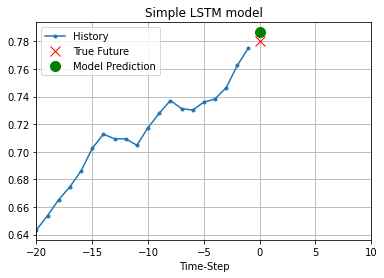

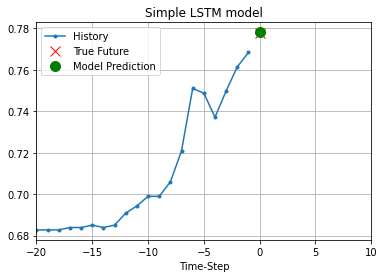

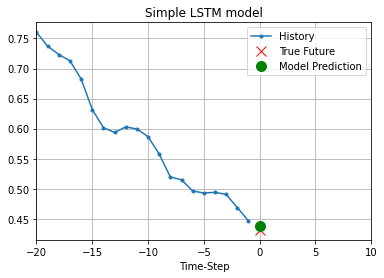

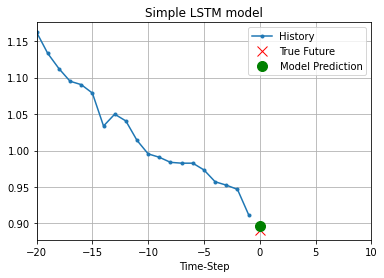

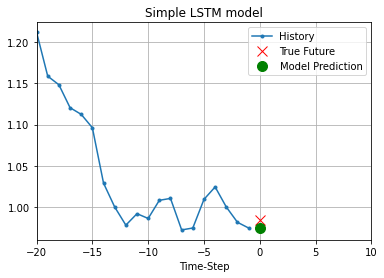

In [ ]:
for x, y in val_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[50].numpy(), y[50].numpy(),
                    simple_lstm_model.predict(x)[50]], 0, 'Simple LSTM model')
  plot.show()

## Multi-variate & single-step forecasting

In [16]:
# Features
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f43cf6ba2d0>,
      dtype=object)

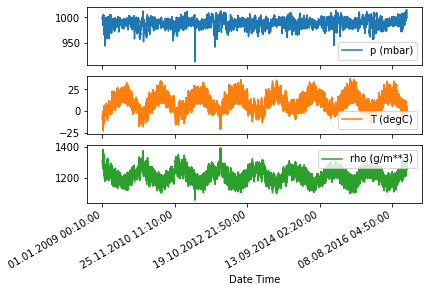

In [ ]:
features.plot(subplots=True)

In [17]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [18]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):                           # history_size:k value  , target_size: at what timestamp you want to predict
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i) 
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [19]:
past_history = 20 
future_target = 0 

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

(299980, 20, 3)
(299980,)


In [27]:
BATCH_SIZE = 256 
BUFFER_SIZE = 10000 
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<RepeatDataset shapes: ((None, 20, 3), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 3), (None,)), types: (tf.float64, tf.float64)>


In [33]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:],return_sequences= True))
single_step_model.add(tf.keras.layers.LSTM(64,return_sequences= True))
single_step_model.add(tf.keras.layers.Dropout(0.5))
single_step_model.add(tf.keras.layers.LSTM(128))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mae')

single_step_model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 20, 32)            4608      
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 64)            24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 128,385
Trainable params: 128,385
Non-trainable params: 0
_________________________________________________________________


In [34]:
STEPS_PER_EPOCH = 200
EPOCHS = 30

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/30
200/200 [==============================] - 6s 13ms/step - loss: 0.2302 - val_loss: 0.0522
Epoch 2/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0737 - val_loss: 0.0450
Epoch 3/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0606 - val_loss: 0.0341
Epoch 4/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0537 - val_loss: 0.0326
Epoch 5/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0456 - val_loss: 0.0303
Epoch 6/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0432 - val_loss: 0.0276
Epoch 7/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0473 - val_loss: 0.0251
Epoch 8/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0417 - val_loss: 0.0286
Epoch 9/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0401 - val_loss: 0.0247
Epoch 10/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0384 - val_loss: 0.025

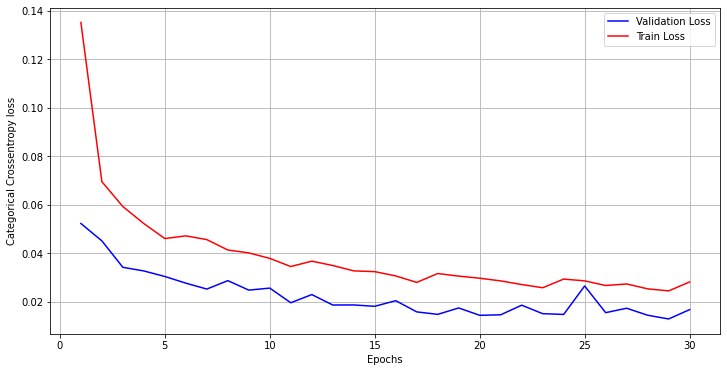

In [37]:
epochs=30
history=single_step_model.history

x=list(range(1,epochs+1))
val_loss=history.history['val_loss']
train_loss=history.history['loss']
plt_train_val_loss(x,val_loss,train_loss)

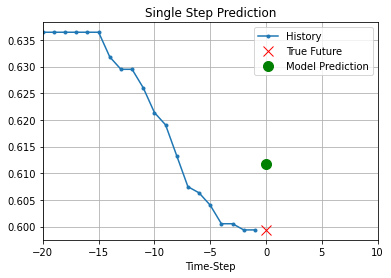

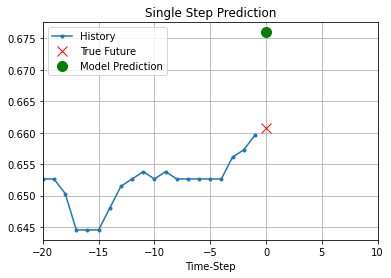

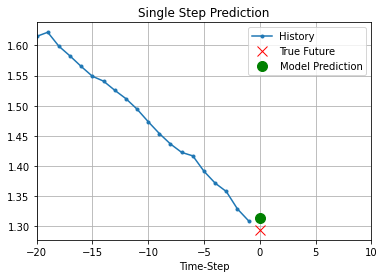

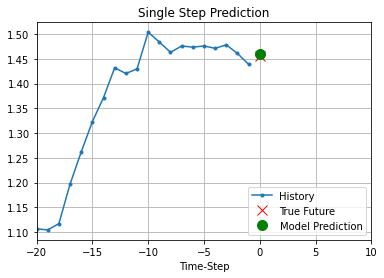

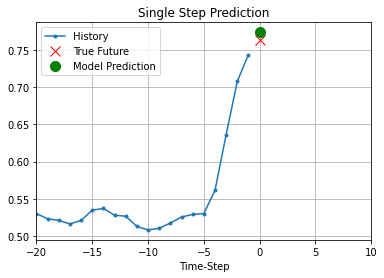

In [42]:
for x, y in val_data_single.take(5):
  plot = show_plot([x[2][:, 1].numpy(), y[2].numpy(),
                    single_step_model.predict(x)[2]], 0,
                   'Single Step Prediction')
  plot.show()

## Multi-variate & multi-step forecasting

In [50]:
future_target = 20
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(299980, 20, 3)
(299980, 20)
(120511, 20, 3)
(120511, 20)


In [55]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print(train_data_multi)
print(val_data_multi)

<RepeatDataset shapes: ((None, 20, 3), (None, 20)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 3), (None, 20)), types: (tf.float64, tf.float64)>


In [52]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), marker='bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), marker='ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

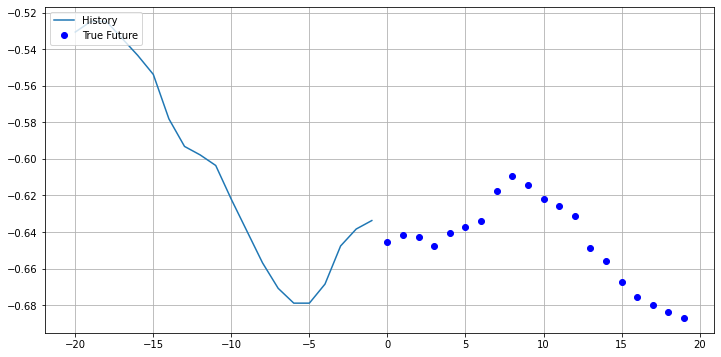

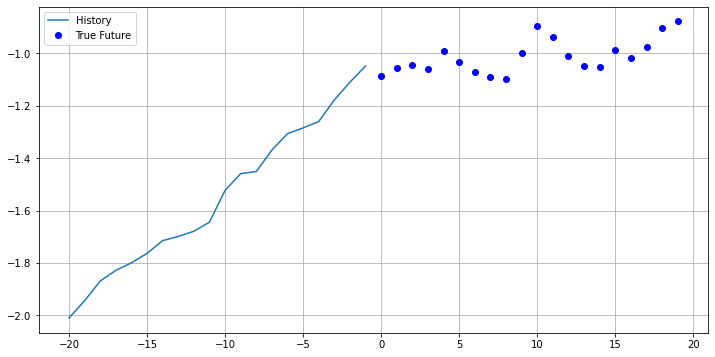

In [78]:
for x, y in train_data_multi.take(2):
  multi_step_plot(x[0], y[0], np.array([0]))

In [66]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(16,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu',return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(20))

multi_step_model.compile(optimizer='adam', loss='mae')
multi_step_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 20, 16)            1280      
_________________________________________________________________
lstm_19 (LSTM)               (None, 20, 32)            6272      
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1300      
Total params: 33,684
Trainable params: 33,684
Non-trainable params: 0
_________________________________________________________________


In [67]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/30
200/200 [==============================] - 15s 63ms/step - loss: 0.5629 - val_loss: 0.1489
Epoch 2/30
200/200 [==============================] - 12s 62ms/step - loss: 0.1630 - val_loss: 0.1160
Epoch 3/30
200/200 [==============================] - 12s 60ms/step - loss: 0.1391 - val_loss: 0.1057
Epoch 4/30
200/200 [==============================] - 12s 59ms/step - loss: 0.1252 - val_loss: 0.0979
Epoch 5/30
200/200 [==============================] - 12s 62ms/step - loss: 0.0987 - val_loss: 0.0959
Epoch 6/30
200/200 [==============================] - 13s 64ms/step - loss: 0.1089 - val_loss: 0.0977
Epoch 7/30
200/200 [==============================] - 13s 63ms/step - loss: 0.1181 - val_loss: 0.0977
Epoch 8/30
200/200 [==============================] - 12s 62ms/step - loss: 0.1150 - val_loss: 0.0911
Epoch 9/30
200/200 [==============================] - 13s 63ms/step - loss: 0.1188 - val_loss: 0.0900
Epoch 10/30
200/200 [==============================] - 12s 61ms/step - loss: 0.109

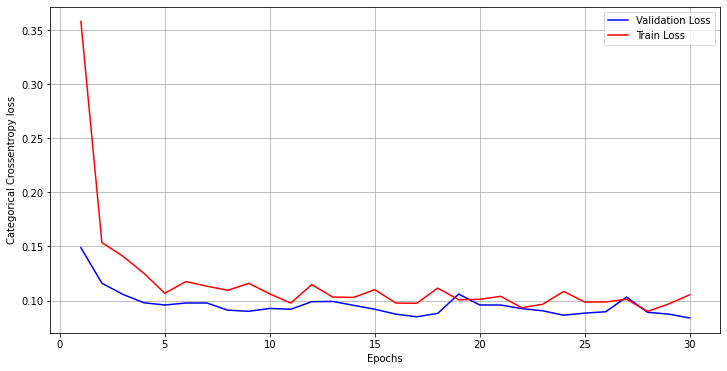

In [68]:
epochs=30
history=multi_step_model.history

x=list(range(1,epochs+1))
val_loss=history.history['val_loss']
train_loss=history.history['loss']
plt_train_val_loss(x,val_loss,train_loss)

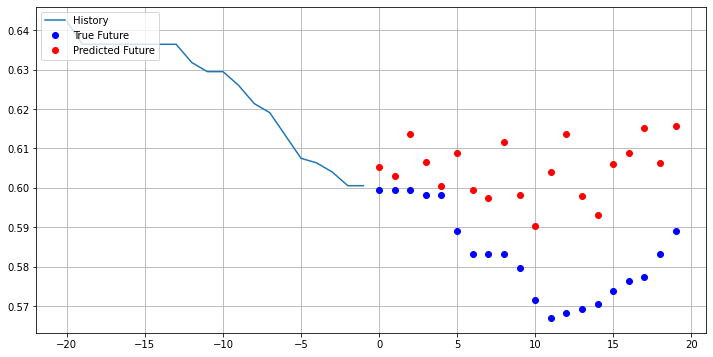

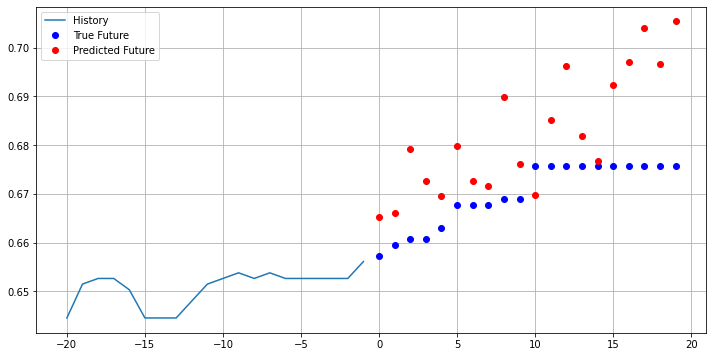

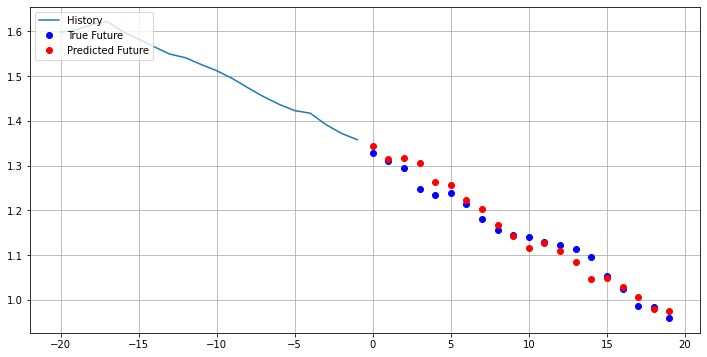

In [77]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])